In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb


## Data Preprocessing

### Address Missingness

In [2]:
# load in data
df_train = pd.read_csv('insurance_t.csv')
df_val = pd.read_csv('insurance_v.csv')

# Find columns with missing data in train and validation datasets
miss_t = [col for col in df_train.columns if df_train[col].isnull().sum() > 0]
miss_v = [col for col in df_val.columns if df_val[col].isnull().sum() > 0]

# Check if train and validation datasets are missing the same columns
print(miss_t == miss_v)

# Check what and how many values are missing in the train dataset
missing_counts_train = df_train[miss_t].isnull().sum()
print(missing_counts_train)

True
ACCTAGE     546
PHONE      1075
POS        1075
POSAMT     1075
INV        1075
INVBAL     1075
CC         1075
CCBAL      1075
CCPURC     1075
INCOME     1537
LORES      1537
HMVAL      1537
AGE        1702
CRSCORE     195
dtype: int64


In [3]:
# Define columns w/ missingness
continuous_cols = ["ACCTAGE", "PHONE", "POS", "POSAMT", "INVBAL", "CCBAL", "INCOME", "LORES", "HMVAL", "AGE", "CRSCORE"]
binary_cols = ["INV", "CC", "CCPURC"]

#replace ns's with 'Missing', 1's w/ 'Instance', 0' w/ 'Non-Instance' for train and val
for col in binary_cols:
    df_train[col] = df_train[col].replace({1: 'Instance', 0: 'Non-Instance'}).fillna('Missing')
    df_val[col] = df_val[col].replace({1: 'Instance', 0: 'Non-Instance'}).fillna('Missing')


#impute with median and create binary flag column
for col in continuous_cols:
    median_value = df_train[col].median()
    # Create a binary flag variable for imputation
    df_train[f'{col}_imputed'] = df_train[col].isnull().astype(int)
    #impute the missing values with the median
    df_train[col].fillna(median_value)

#do the same for val
for col in continuous_cols:
    median_value = df_train[col].median()
    # Create a binary flag variable for imputation
    df_val[f'{col}_imputed'] = df_val[col].isnull().astype(int)
    #impute the missing values with the median
    df_val[col].fillna(median_value)

### One-Hot Encode

In [4]:
# Separate binary columns and categorical columns for one-hot encoding
binary_columns = [
    "INAREA", "SDB", "MM", "IRA", "CD", "ATM", "SAV", "NSF", "DIRDEP", "DDA", "ACCTAGE_imputed", "PHONE_imputed", "POS_imputed", 
    "POSAMT_imputed", "INVBAL_imputed", "CCBAL_imputed", 
    "INCOME_imputed", "LORES_imputed", "HMVAL_imputed", 
    "AGE_imputed", "CRSCORE_imputed"
]

categorical_columns = [
    "INV", "CC", "CCPURC", "BRANCH"
]

# Apply one-hot encoding only to the specified categorical columns
df_train = pd.get_dummies(df_train, columns=categorical_columns, drop_first=True)
df_val = pd.get_dummies(df_val, columns=categorical_columns, drop_first=True)

# Label encode the MMCRED column in both datasets
label_encoder = LabelEncoder()
df_train['MMCRED'] = label_encoder.fit_transform(df_train['MMCRED'])
df_val['MMCRED'] = label_encoder.transform(df_val['MMCRED'])

# Ensure both train and validation have the same columns
df_val = df_val.reindex(columns=df_train.columns, fill_value=0)

# Convert binary columns to 0/1 (if needed)
for col in binary_columns:
    df_train[col] = df_train[col].astype(int)
    df_val[col] = df_val[col].astype(int)

In [5]:
# Define X as all columns except 'INS' and y as the 'INS' column
X_train = df_train.drop(columns=['INS'])
y_train = df_train['INS']

X_val = df_val.drop(columns=['INS'])
y_val = df_val['INS']

## Random Forest Model

### Hyperparameter Tuning

In [ ]:
# define the rf estimator
rf = RandomForestClassifier(random_state = 88)

# number of trees (estimators/weak models) in Bagging
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 100)]
# number of features to consider at every split
max_features = ['sqrt', 'log2']
# minimum number of samples at leaf node
min_samples_leaf = [1, 2, 4, 6, 8, 10]
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# Create the random grid
random_params = {'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth,
 'min_samples_leaf': min_samples_leaf}

In [41]:
rf_gs = RandomizedSearchCV(estimator = rf, param_distributions = random_params,
                           n_iter = 100, cv = 3, verbose = 1, random_state=88)

# Fit the random search model
rf_gs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=88),
                   n_iter=100,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...]},
                   random_state=88, verbose=1)

In [42]:
rf_gs.best_params_

{'n_estimators': 770,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 90}

### Variable Importance

In [26]:
#add in an uncorrelated and random x
X_train_r = X_train
X_train_r['random'] = np.random.normal(0, 1, X_train.shape[0])

In [13]:
#Fit model with the random variable using best parameters from above RandomGridSearch
best_rf = RandomForestClassifier(n_estimators=770,min_samples_leaf=2,max_features='sqrt', max_depth=90, random_state = 88, oob_score=True)
best_rf.fit(X_train_r,y_train)

RandomForestClassifier(max_depth=90, min_samples_leaf=2, n_estimators=770,
                       oob_score=True, random_state=88)

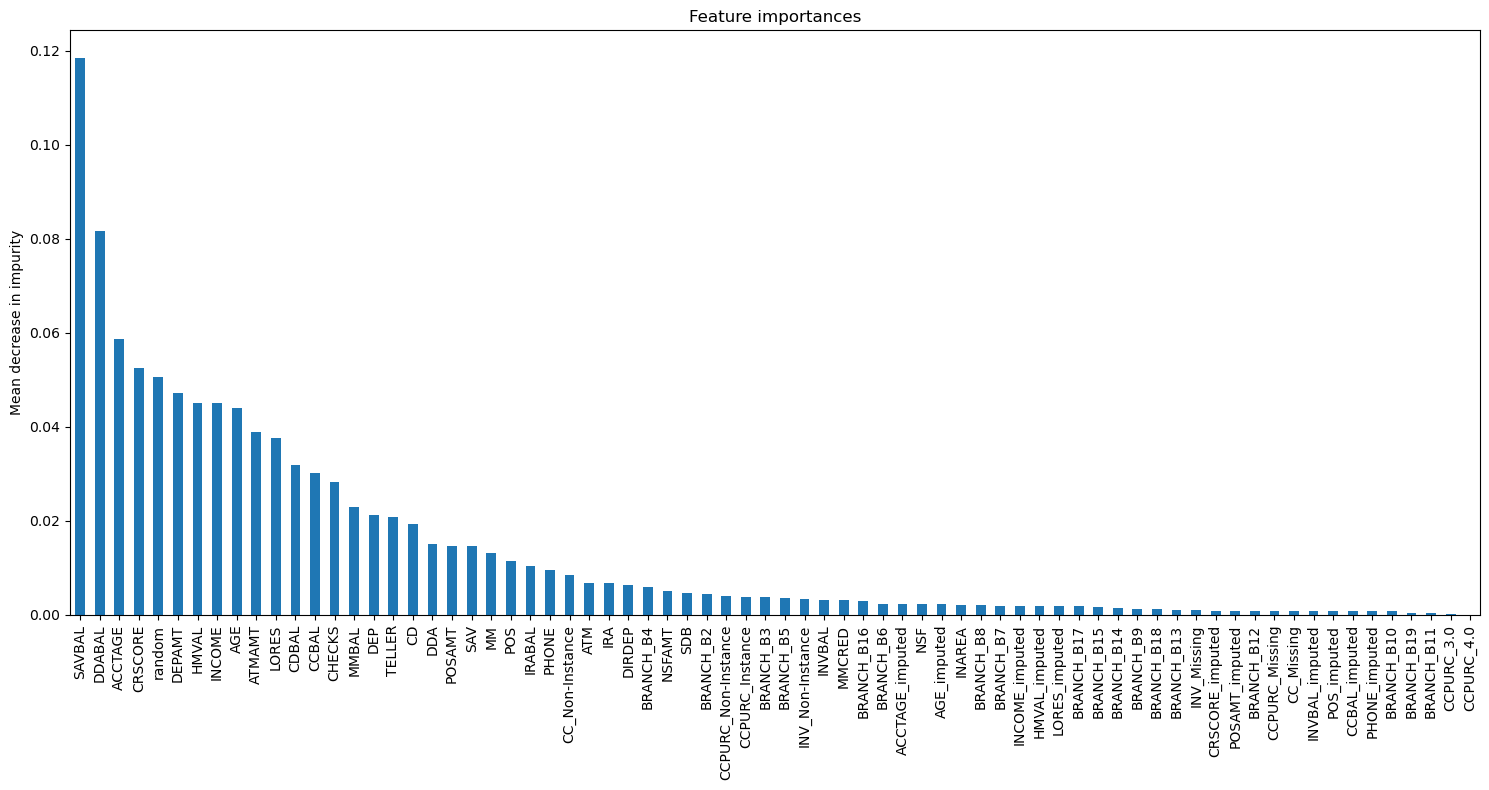

In [ ]:
#grab the most important feature
forest_importances = pd.Series(best_rf.feature_importances_, index = best_rf.feature_names_in_).sort_values(ascending=False)

#plot the most important features
fig, ax = plt.subplots(figsize=(15, 8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [21]:
forest_importances

SAVBAL        0.118457
DDABAL        0.081726
ACCTAGE       0.058619
CRSCORE       0.052514
random        0.050552
                ...   
BRANCH_B10    0.000748
BRANCH_B19    0.000423
BRANCH_B11    0.000398
CCPURC_3.0    0.000269
CCPURC_4.0    0.000008
Length: 72, dtype: float64

We see that SAVBAL, DDABAL, ACCTAGE, CRSCORE are the vars more infulential than a random x.

### AUC & ROC

In [7]:
#Fit model with the all variables using best parameters from above RandomGridSearch
best_rf = RandomForestClassifier(n_estimators=770,min_samples_leaf=2,max_features='sqrt', max_depth=90, random_state = 88, oob_score=True)
best_rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=90, min_samples_leaf=2, n_estimators=770,
                       oob_score=True, random_state=88)

Area under the ROC curve (AUC): 0.7959


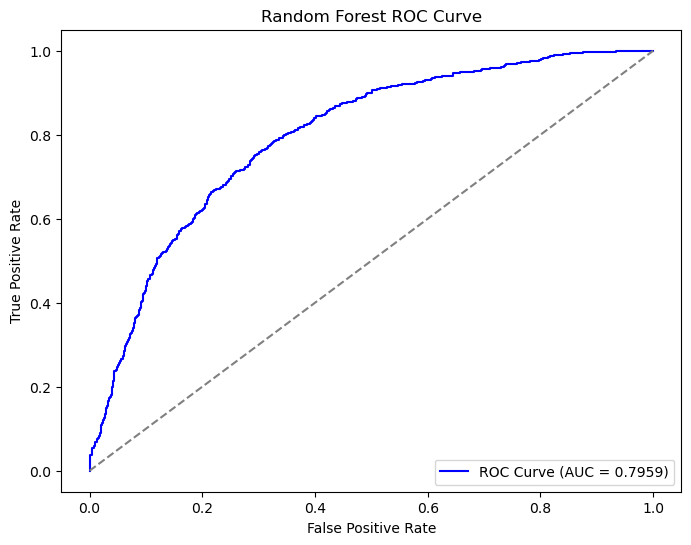

In [15]:
#probabilities for the positive class on the test set
y_pred_proba = best_rf.predict_proba(X_val)[:, 1]  # Get probabilities for class 1

#AUC score using the test labels
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f"Area under the ROC curve (AUC): {auc_score:.4f}")


#calculate the ROC curve using test labels and predicted probabilities
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [16]:
#probabilities for the positive class on the test set
y_pred_proba = best_rf.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

#AUC score using the test labels
auc_score = roc_auc_score(y_train, y_pred_proba)
print(f"Area under the ROC curve (AUC): {auc_score:.4f}")

Area under the ROC curve (AUC): 0.9988


## XGBoost

### Hyperparameter Tuning

In [23]:
xgb_clf = xgb.XGBClassifier(random_state = 88)

# RandomsearchCV Parameters
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 2000, num = 200)],
    'eta': [0.1, 0.15, 0.2, 0.25, 0.3],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.25, 0.5, 0.75, 1]
}

In [24]:
xgb_rs = RandomizedSearchCV(estimator = xgb_clf, param_distributions = param_grid, n_iter = 100, cv = 5, 
                            verbose = 1, random_state=88)

# Fit the random search model
xgb_rs.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=88, ...),
                   n_iter=100,
                   param_distributions={'eta': [0.1, 0.15, 0.2, 0.25, 0.3],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200, 210, 220, 230,
                                                         240, 250, 260, 270,
                                                         280, 290, 300, ...],
                                        'subsample': [0.25, 0.5, 0.75, 1]},
                   random_state=88, verbose=1)

In [25]:
# best hyper parameters
xgb_rs.best_params_

{'subsample': 0.5, 'n_estimators': 210, 'max_depth': 4, 'eta': 0.1}

### Variable Importance

In [39]:
#Fit model with the random variable using best parameters from above RandomGridSearch
tune_xbg_cls = xgb.XGBClassifier(n_estimators = 210, subsample = 0.5, eta = 0.1, max_depth = 4, random_state = 88)
tune_xbg_cls.fit(X_train_r,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=210,
              n_jobs=None, num_parallel_tree=None, ...)

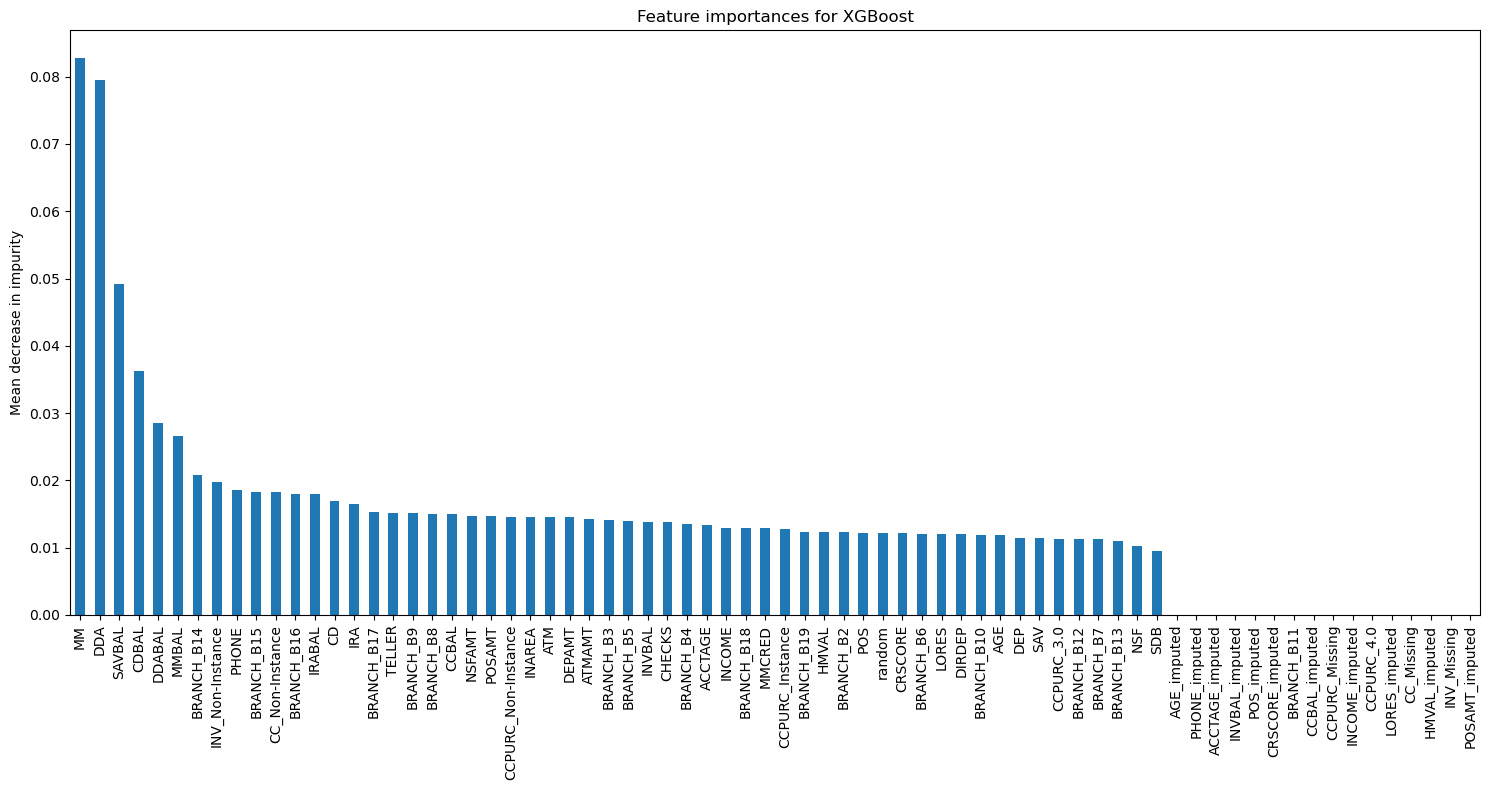

In [40]:
#grab the most important feature
xgb_importances = pd.Series(tune_xbg_cls.feature_importances_, index = tune_xbg_cls.feature_names_in_).sort_values(ascending=False)

#plot the most important features
fig, ax = plt.subplots(figsize=(15, 8))
xgb_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for XGBoost")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [41]:
#grab all varriables that are more important than the random x
important = xgb_importances[xgb_importances > xgb_importances['random']]
important

MM                     0.082756
DDA                    0.079539
SAVBAL                 0.049168
CDBAL                  0.036277
DDABAL                 0.028575
MMBAL                  0.026597
BRANCH_B14             0.020760
INV_Non-Instance       0.019692
PHONE                  0.018631
BRANCH_B15             0.018276
CC_Non-Instance        0.018230
BRANCH_B16             0.018025
IRABAL                 0.017956
CD                     0.016989
IRA                    0.016492
BRANCH_B17             0.015225
TELLER                 0.015209
BRANCH_B9              0.015203
BRANCH_B8              0.014980
CCBAL                  0.014951
NSFAMT                 0.014711
POSAMT                 0.014666
CCPURC_Non-Instance    0.014625
INAREA                 0.014556
ATM                    0.014549
DEPAMT                 0.014518
ATMAMT                 0.014184
BRANCH_B3              0.014057
BRANCH_B5              0.013915
INVBAL                 0.013874
CHECKS                 0.013744
BRANCH_B

### ROC & AUC

In [44]:
#Fit model with the all variables using best parameters from above RandomGridSearch
final_xbg_cls = xgb.XGBClassifier(n_estimators = 210, subsample = 0.5, eta = 0.1, max_depth = 4, random_state = 88)
final_xbg_cls.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=210,
              n_jobs=None, num_parallel_tree=None, ...)

In [47]:
# Step 1: Predict probabilities for the positive class on the test set
y_pred_proba = final_xbg_cls.predict_proba(X_val)[:, 1]  # Get probabilities for class 1

# Step 2: Calculate the AUC score using the test labels
auc_score = roc_auc_score(y_val, y_pred_proba)
print(f"Area under the ROC curve (AUC): {auc_score:.4f}")

# Step 3: Calculate the ROC curve using test labels and predicted probabilities
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Step 4: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ValueError: feature_names mismatch: ['ACCTAGE', 'DDA', 'DDABAL', 'DEP', 'DEPAMT', 'CHECKS', 'DIRDEP', 'NSF', 'NSFAMT', 'PHONE', 'TELLER', 'SAV', 'SAVBAL', 'ATM', 'ATMAMT', 'POS', 'POSAMT', 'CD', 'CDBAL', 'IRA', 'IRABAL', 'INVBAL', 'MM', 'MMBAL', 'MMCRED', 'CCBAL', 'SDB', 'INCOME', 'LORES', 'HMVAL', 'AGE', 'CRSCORE', 'INAREA', 'ACCTAGE_imputed', 'PHONE_imputed', 'POS_imputed', 'POSAMT_imputed', 'INVBAL_imputed', 'CCBAL_imputed', 'INCOME_imputed', 'LORES_imputed', 'HMVAL_imputed', 'AGE_imputed', 'CRSCORE_imputed', 'INV_Missing', 'INV_Non-Instance', 'CC_Missing', 'CC_Non-Instance', 'CCPURC_3.0', 'CCPURC_4.0', 'CCPURC_Instance', 'CCPURC_Missing', 'CCPURC_Non-Instance', 'BRANCH_B10', 'BRANCH_B11', 'BRANCH_B12', 'BRANCH_B13', 'BRANCH_B14', 'BRANCH_B15', 'BRANCH_B16', 'BRANCH_B17', 'BRANCH_B18', 'BRANCH_B19', 'BRANCH_B2', 'BRANCH_B3', 'BRANCH_B4', 'BRANCH_B5', 'BRANCH_B6', 'BRANCH_B7', 'BRANCH_B8', 'BRANCH_B9', 'random'] ['ACCTAGE', 'DDA', 'DDABAL', 'DEP', 'DEPAMT', 'CHECKS', 'DIRDEP', 'NSF', 'NSFAMT', 'PHONE', 'TELLER', 'SAV', 'SAVBAL', 'ATM', 'ATMAMT', 'POS', 'POSAMT', 'CD', 'CDBAL', 'IRA', 'IRABAL', 'INVBAL', 'MM', 'MMBAL', 'MMCRED', 'CCBAL', 'SDB', 'INCOME', 'LORES', 'HMVAL', 'AGE', 'CRSCORE', 'INAREA', 'ACCTAGE_imputed', 'PHONE_imputed', 'POS_imputed', 'POSAMT_imputed', 'INVBAL_imputed', 'CCBAL_imputed', 'INCOME_imputed', 'LORES_imputed', 'HMVAL_imputed', 'AGE_imputed', 'CRSCORE_imputed', 'INV_Missing', 'INV_Non-Instance', 'CC_Missing', 'CC_Non-Instance', 'CCPURC_3.0', 'CCPURC_4.0', 'CCPURC_Instance', 'CCPURC_Missing', 'CCPURC_Non-Instance', 'BRANCH_B10', 'BRANCH_B11', 'BRANCH_B12', 'BRANCH_B13', 'BRANCH_B14', 'BRANCH_B15', 'BRANCH_B16', 'BRANCH_B17', 'BRANCH_B18', 'BRANCH_B19', 'BRANCH_B2', 'BRANCH_B3', 'BRANCH_B4', 'BRANCH_B5', 'BRANCH_B6', 'BRANCH_B7', 'BRANCH_B8', 'BRANCH_B9']
expected random in input data